In [1]:
from platform import python_version

assert (
    python_version() == "3.11.0"
), "Running on other python version may cause problems"

In [2]:
from image_loader import ImageLoader

import os
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

MATPLOTLIB_CMAP_GRAY = (
    "gray"  # old versions of Matplotlib does not support "grey" as the colormap name
)

DATA_PROCESSED_PATH = Path(".", "..", "data", "preprocessed")

# Define enabled traps indices

In [3]:
TEXPS = np.arange(2.0, 9.1, 0.5)
RB_CURRENTS = np.array([3.2])

TARGET_INDICES = np.array(
    [
        22,
        23,
        24,
        25,
        26,
        27,
        32,
        33,
        36,
        37,
        38,
        39,
        40,
        43,
        44,
        45,
        46,
        47,
        48,
        49,
        52,
        53,
        54,
        55,
        56,
        59,
        60,
        61,
        62,
        63,
        64,
        65,
        68,
        69,
        70,
        71,
        72,
        75,
        76,
        81,
        82,
        83,
        84,
        85,
        86,
    ]
)
# 20 perepherial + 25 center = 45
assert TARGET_INDICES.shape[0] == 45, "Wrong traps alignment"
TARGET_INDICES

array([22, 23, 24, 25, 26, 27, 32, 33, 36, 37, 38, 39, 40, 43, 44, 45, 46,
       47, 48, 49, 52, 53, 54, 55, 56, 59, 60, 61, 62, 63, 64, 65, 68, 69,
       70, 71, 72, 75, 76, 81, 82, 83, 84, 85, 86])

# Process all data

In [4]:
# !rm ./2024_11_17_processed.hdf5
CUT_TRAPS_PATH = DATA_PROCESSED_PATH / "cut_traps.hdf5"

if os.path.exists(CUT_TRAPS_PATH):
    os.remove(CUT_TRAPS_PATH)
    print(f"File '{CUT_TRAPS_PATH}' has been removed.")
else:
    print(f"File '{CUT_TRAPS_PATH}' does not exist.")

File '../data/preprocessed/cut_traps.hdf5' has been removed.


In [5]:
from itertools import product


def process_data_return_clean_file(trap_radius: float = 3.5):
    TEXPS = np.arange(2.0, 9.1, 0.5)
    RB_CURRENTS = np.array([3.2])
    image_size = int(trap_radius * 2 + 1) # for trap_radius = 3.5: image_size = 8

    for texp, rb_current in tqdm(product(TEXPS, RB_CURRENTS), total=TEXPS.shape[0] * RB_CURRENTS.shape[0]):
        iml_large = ImageLoader(
            datapath=Path(
                ".",
                "..",
                "data",
                "raw"
            ),
            exposure_time_ms=texp,
            pattern=f"rb{rb_current:.1f}_*_*_*.png",
        )

        with h5py.File(CUT_TRAPS_PATH, "a") as f:
            g = f.require_group(f"rb_{rb_current:.1f}")
            gg = g.require_group(f"texp_{texp:.1f}")
            ggg_first_img_traps = gg.require_group("first")
            ggg_second_img_traps = gg.require_group("second")
            ggg_third_img_traps = gg.require_group("third")

            # set data
            for trap_ind in TARGET_INDICES:
                iml_large.update_mask(trap_inds=[trap_ind], trap_radius=trap_radius)

                arr_first = iml_large.remasked_data_first[::, iml_large.mask].reshape(
                    -1, image_size, image_size
                )
                assert arr_first.shape[0] == 1000, "Wrong first mage data shape"
                _ = ggg_first_img_traps.create_dataset(
                    f"trap_{trap_ind}",
                    data=arr_first,
                    compression="gzip",
                )

                arr_second = iml_large.remasked_data_second[::, iml_large.mask].reshape(
                    -1, image_size, image_size
                )
                assert arr_second.shape[0] == 1000, "Wrong second mage data shape"
                _ = ggg_second_img_traps.create_dataset(
                    f"trap_{trap_ind}",
                    data=arr_second,
                    compression="gzip",
                )

                arr_third = iml_large.remasked_data_third[::, iml_large.mask].reshape(
                    -1, image_size, image_size
                )
                assert arr_third.shape[0] == 1000, "Wrong third mage data shape"
                _ = ggg_third_img_traps.create_dataset(
                    f"trap_{trap_ind}",
                    data=arr_third,
                    compression="gzip",
                )

In [6]:
process_data_return_clean_file() # takes about 1 minute

  0%|          | 0/15 [00:00<?, ?it/s]INFO:image_loader:Initialized ImageLoader in path: /home/ctrlc0ctrlv/lab/detection/three_images/arxiv_article_code/RB87_IMAGING_TIME_REDUCTION/data/raw
INFO:image_loader:self.dirfiles size = 3000
  7%|▋         | 1/15 [00:03<00:48,  3.48s/it]INFO:image_loader:Initialized ImageLoader in path: /home/ctrlc0ctrlv/lab/detection/three_images/arxiv_article_code/RB87_IMAGING_TIME_REDUCTION/data/raw
INFO:image_loader:self.dirfiles size = 3000
 13%|█▎        | 2/15 [00:07<00:45,  3.51s/it]INFO:image_loader:Initialized ImageLoader in path: /home/ctrlc0ctrlv/lab/detection/three_images/arxiv_article_code/RB87_IMAGING_TIME_REDUCTION/data/raw
INFO:image_loader:self.dirfiles size = 3000
 20%|██        | 3/15 [00:10<00:39,  3.31s/it]INFO:image_loader:Initialized ImageLoader in path: /home/ctrlc0ctrlv/lab/detection/three_images/arxiv_article_code/RB87_IMAGING_TIME_REDUCTION/data/raw
INFO:image_loader:self.dirfiles size = 3000
 27%|██▋       | 4/15 [00:12<00:33,  3.0

# Check data processing

A group of histograms should be seen:
- Blue peaks - stable
- Orange peaks:
    - left peak is stable (empty traps)
    - right peak is moving right when increasing $\tau_\text{exp}$ (filled traps)

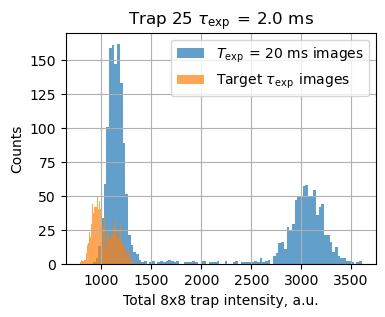

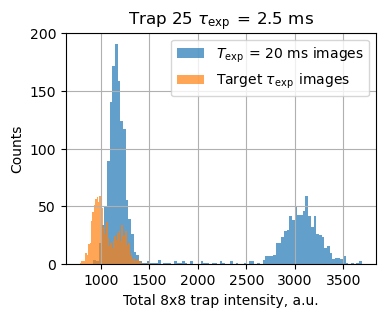

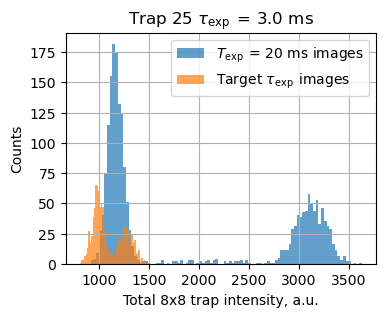

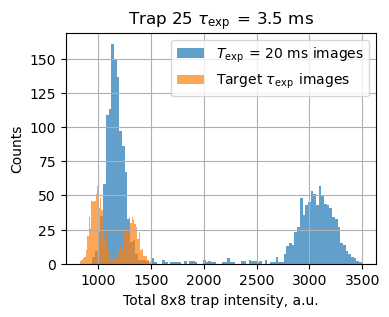

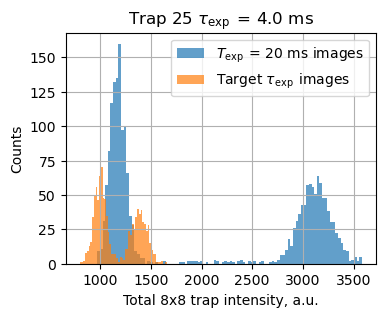

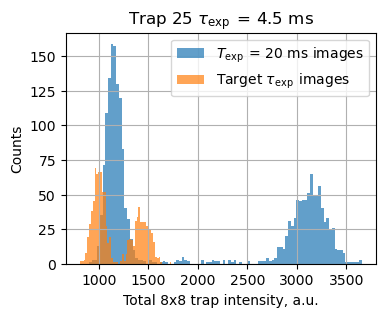

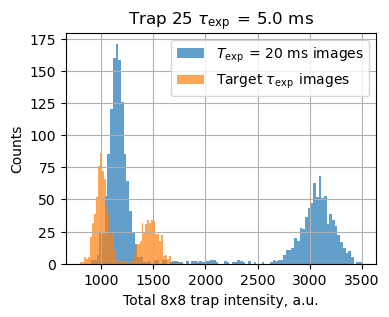

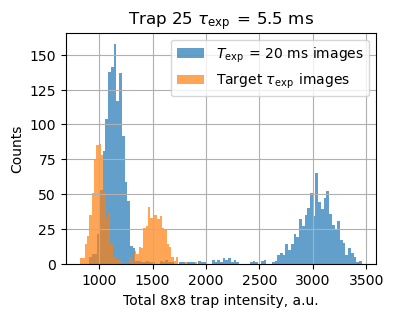

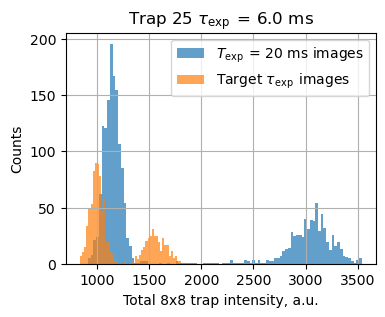

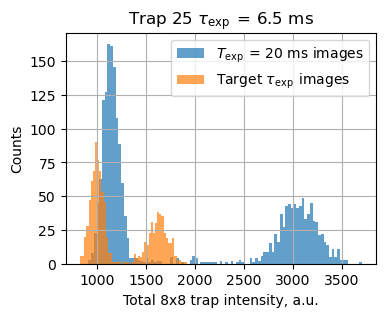

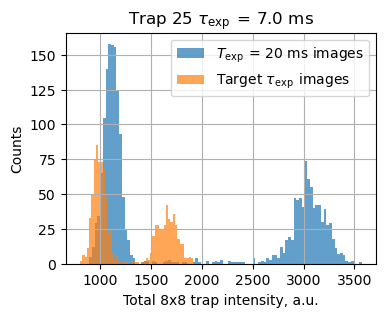

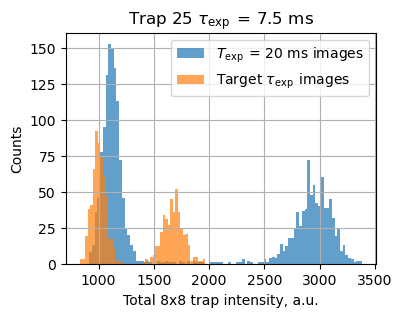

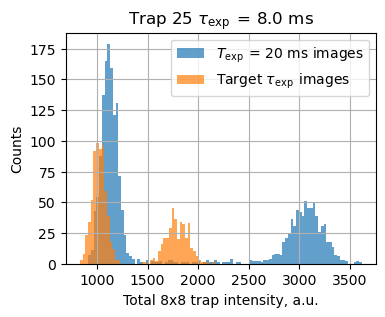

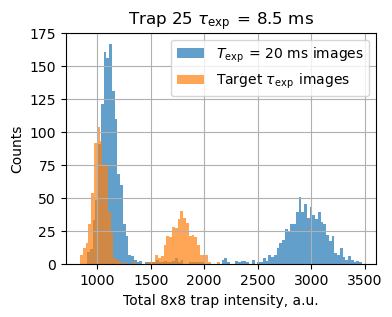

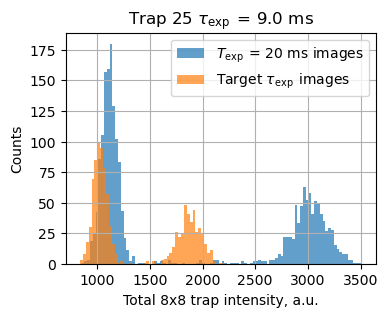

In [7]:
with h5py.File(CUT_TRAPS_PATH, "r") as f:
    TEXPS = np.arange(2.0, 9.1, 0.5)

    rb_current = 3.2
    trap_ind = 25
    for texp in TEXPS:
        # get data
        d = f[f"rb_{rb_current:.1f}/texp_{texp:.1f}/first/trap_{trap_ind}"]
        arr_first = d[::]

        d = f[f"rb_{rb_current:.1f}/texp_{texp:.1f}/second/trap_{trap_ind}"]
        arr_second = d[::]

        d = f[f"rb_{rb_current:.1f}/texp_{texp:.1f}/third/trap_{trap_ind}"]
        arr_third = d[::]
        
        assert arr_first.shape == arr_second.shape == arr_third.shape, "Data shape mismatch"

        fig = plt.figure(figsize=(4, 3))
        plt.hist(
            np.concatenate([arr_first.sum(axis=(1, 2)), arr_third.sum(axis=(1, 2))]),
            bins=100,
            color="C0",
            label="$T_\exp$ = 20 ms images",
            alpha=0.7,
        )
        plt.hist(
            arr_second.sum(axis=(1, 2)),
            bins=50,
            color="C1",
            label=r"Target $\tau_\exp$ images",
            alpha=0.7,
        )
        plt.title(f"Trap {trap_ind} " + r"$\tau_\exp$" + f" = {texp} ms")
        plt.xlabel(f"Total {arr_first.shape[1]}x{arr_first.shape[2]} trap intensity, a.u.")
        plt.ylabel("Counts")
        plt.grid()
        plt.legend()
        plt.show()